The NHS 10 year plan comits the NHS to shifting from MDI to DPI. This notebook seeks to describe the trends and variation and model the cost of such a policy on the medicines budget

In [1]:
### here we import various libraries needed
import pandas as pd
import numpy as np
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd


In [2]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  pct,
  pract.name,
  presc.practice,
  AVG(total_list_size) AS list_size,
  presc.month,
  SUM(IF(form_route='powderinhalation.inhalation', ##from dmd, identifies a DPI 
      items,
      0)) AS dpi,
      SUM(IF(form_route='pressurizedinhalation.inhalation',  ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
      SUM(items) AS totalinhalers,
    SUM(actual_cost) AS totalcost
   FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
  LEFT JOIN  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  pct,
  name,
  practice,  
  month
  '''


df_inhaler = bq.cached_read(sql, csv_path='df_inhaler.csv', use_cache=True)  # add `use_cache=False` to override
df_inhaler['month'] = df_inhaler['month'].astype('datetime64[ns]')
df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost
0,99P,WATERSIDE PRACTICE,L83017,9932.0,2015-08-01,397,865,1262,26281.41
1,15F,DR T P FOX & PARTNERS,B86075,12159.0,2015-08-01,546,618,1164,30616.56
2,07V,BIRDHURST MEDICAL PRACTICE,H83627,6249.0,2015-08-01,49,166,215,3942.85
3,04J,STEWART MEDICAL CENTRE,C81034,9523.0,2015-08-01,171,476,647,17484.58
4,99J,BEARSTED,G82074,12877.0,2015-08-01,403,563,966,23284.26


In [3]:
# here we calculate current proportion of inhalers prescribed as DPI
df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)

df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi
0,99P,WATERSIDE PRACTICE,L83017,9932.0,2015-08-01,397,865,1262,26281.41,31.458003
1,15F,DR T P FOX & PARTNERS,B86075,12159.0,2015-08-01,546,618,1164,30616.56,46.907216
2,07V,BIRDHURST MEDICAL PRACTICE,H83627,6249.0,2015-08-01,49,166,215,3942.85,22.790698
3,04J,STEWART MEDICAL CENTRE,C81034,9523.0,2015-08-01,171,476,647,17484.58,26.429675
4,99J,BEARSTED,G82074,12877.0,2015-08-01,403,563,966,23284.26,41.718427


In [4]:
# here I repeated this...........this isproblem when doing in snatched time and big gaps in between!
pc = df_inhaler.copy()
pc["percentage_dpi"] = 100*(pc.dpi/(pc.dpi+pc.mdi)).fillna(0)
pc.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi,percentage_dpi
0,99P,WATERSIDE PRACTICE,L83017,9932.0,2015-08-01,397,865,1262,26281.41,31.458003,31.458003
1,15F,DR T P FOX & PARTNERS,B86075,12159.0,2015-08-01,546,618,1164,30616.56,46.907216,46.907216
2,07V,BIRDHURST MEDICAL PRACTICE,H83627,6249.0,2015-08-01,49,166,215,3942.85,22.790698,22.790698
3,04J,STEWART MEDICAL CENTRE,C81034,9523.0,2015-08-01,171,476,647,17484.58,26.429675,26.429675
4,99J,BEARSTED,G82074,12877.0,2015-08-01,403,563,966,23284.26,41.718427,41.718427


In [5]:
pc.practice.drop_duplicates().count()

11031

In [6]:
# filter for "normal" practices
filtered = df_inhaler.copy().loc[(df_inhaler.list_size>1000) & (df_inhaler["month"]>"2010-09-01") ]  
filtered.head()

#deciles,perecentiles etc.

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(5)

,month,percentile,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
0,2010-10-01,0.1,2344.4,38.0,109.0,160.0,3626.638,17.035869
1,2010-10-01,0.2,3136.4,59.0,158.0,228.0,5314.334,20.836673
2,2010-10-01,0.3,4017.6,79.0,206.0,294.0,7090.540,23.547333
3,2010-10-01,0.4,4991.6,100.0,258.0,369.0,9010.118,26.069880
4,2010-10-01,0.5,6040.0,125.0,316.0,454.0,11143.170,28.571429


In [7]:
filtered.practice.drop_duplicates().count()

8118

## Current trends in prescribing

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


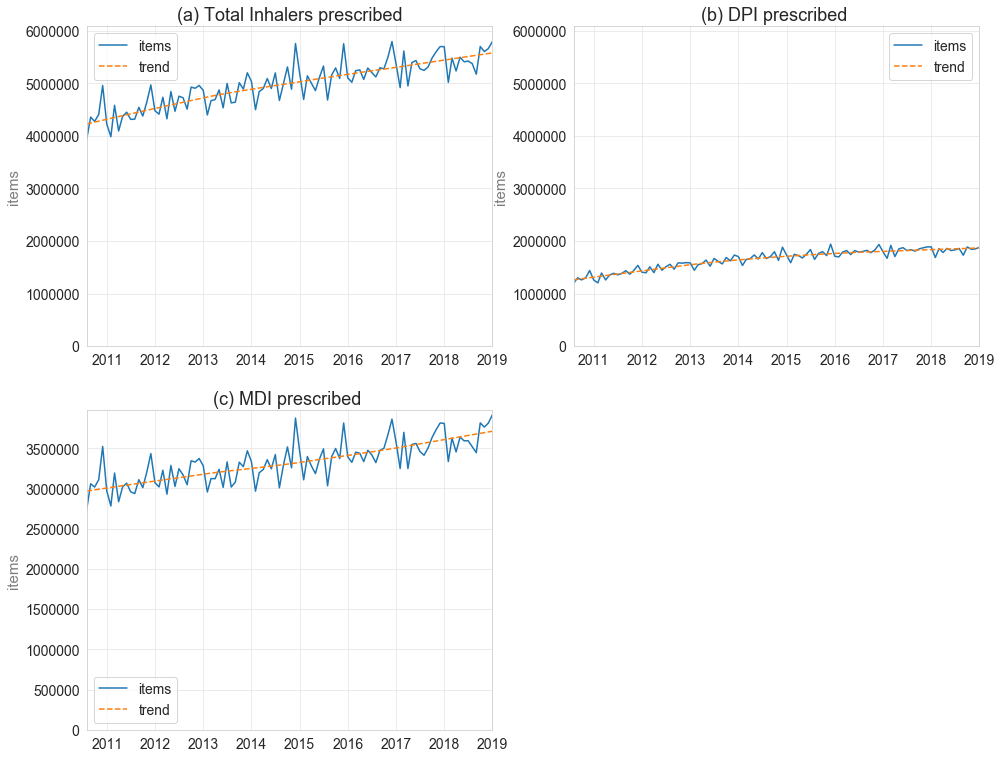

In [8]:
# here we code for plots of current prescribing trends over time

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = df_inhaler.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = df_inhaler.groupby('month').sum()[['totalinhalers','list_size']]
data = pd.DataFrame(data['totalinhalers'])
data["totalinhalers"] = data["totalinhalers"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100

#total inhalers
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(a) Total Inhalers prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["totalinhalers"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#total DPI inahlers
ax = plt.subplot(gs[0,1])
data = df_inhaler.groupby('month').sum()[['dpi', 'list_size']]
data = pd.DataFrame(data['dpi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(b) DPI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#MDI Inhalers
ax = plt.subplot(gs[1,0])
data = df_inhaler.groupby('month').sum()[['mdi','list_size']]
data = pd.DataFrame(data['mdi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(c) MDI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})

plt.show()

# Practice Deciles of DPI Usage

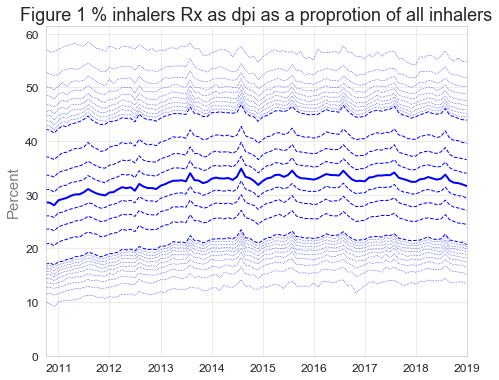

In [9]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'per_dpi',0,0,'Figure 1 % inhalers Rx as dpi as a proprotion of all inhalers','Percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show() 

In [10]:
pcf.head()

,month,percentile,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
0,2010-10-01,0.1,2344.4,38.0,109.0,160.0,3626.638,17.035869
1,2010-10-01,0.2,3136.4,59.0,158.0,228.0,5314.334,20.836673
2,2010-10-01,0.3,4017.6,79.0,206.0,294.0,7090.540,23.547333
3,2010-10-01,0.4,4991.6,100.0,258.0,369.0,9010.118,26.069880
4,2010-10-01,0.5,6040.0,125.0,316.0,454.0,11143.170,28.571429


In [11]:
pcf_jan19 = pcf[pcf.month == '2019-01-01']
pcf_jan19

,month,percentile,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
2673,2019-01-01,0.10,3226.30,72.00,172.00,261.00,5095.290783,20.678050
2674,2019-01-01,0.20,4293.00,105.60,249.00,368.00,7268.869276,24.462284
2675,2019-01-01,0.30,5326.90,140.00,317.00,471.00,9443.796089,27.099103
2676,2019-01-01,0.40,6432.40,176.00,388.00,575.00,11664.912202,29.338843
2677,2019-01-01,0.50,7560.00,216.00,467.00,698.00,14286.831920,31.626313
2678,2019-01-01,0.60,8846.40,264.00,556.00,829.00,17200.679034,34.004311
2679,2019-01-01,0.70,10319.20,320.00,668.00,991.00,20522.858279,36.521739
2680,2019-01-01,0.80,12048.40,401.00,802.00,1206.00,24872.027080,39.605716
2681,2019-01-01,0.90,14855.20,527.70,1047.00,1543.70,31716.644673,43.898124
2682,2019-01-01,0.01,1761.91,23.00,69.00,104.00,1911.632219,13.371422


### Maps for 2018

In [12]:
#aggregate over 2018
ccg_last_year = df_inhaler.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[(ccg_last_year["month"]>="2018-01-01") & (ccg_last_year["month"]<="2018-12-01")]

#ccg_last_year = all_inhalers_ccg.loc[all_inhalers_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)
df_inhaler["costperinh"] = (df_inhaler.totalcost/df_inhaler.totalinhalers).fillna(0)

ccg_last_year["per_dpi"] = 100*(ccg_last_year.dpi/(ccg_last_year.dpi+ccg_last_year.mdi)).fillna(0)


ccg_last_year.head()

,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
pct,,,,,,
00C,108423.333333,59653,80420,140073,3.236474e+06,42.587080
00D,292336.000000,214874,320164,535038,1.058912e+07,40.160512
00J,259779.833333,142789,214871,357660,7.242765e+06,39.923111
00K,297508.166667,183635,292898,476533,1.009143e+07,38.535631
00L,325704.916667,221356,247103,468459,1.021576e+07,47.251947


In [13]:
ccg_last_year['totalcost'].sum()

1392131526.3289802

In [14]:
sql='''
SELECT
  DISTINCT code,
  name
FROM
  ebmdatalab.hscic.ccgs
WHERE
  name IS NOT NULL'''

names = bq.cached_read(sql, csv_path='names.csv', use_cache=True)
names.head(5)

,code,name
0,00T,NHS BOLTON CCG
1,14C,WEST MIDLANDS COMMISSIONING HUB
2,05N,NHS SHROPSHIRE CCG
3,01E,NHS GREATER PRESTON CCG
4,11H,NHS BRISTOL CCG


In [15]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() 

,pct,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi,code
name,,,,,,,,
NHS DARLINGTON CCG,00C,108423.333333,59653,80420,140073,3.236474e+06,42.587080,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,292336.000000,214874,320164,535038,1.058912e+07,40.160512,00D
NHS NORTH DURHAM CCG,00J,259779.833333,142789,214871,357660,7.242765e+06,39.923111,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,297508.166667,183635,292898,476533,1.009143e+07,38.535631,00K
NHS NORTHUMBERLAND CCG,00L,325704.916667,221356,247103,468459,1.021576e+07,47.251947,00L


In [17]:
from urllib.request import urlopen
from urllib.request import Request
import json
url = "https://openprescribing.net/api/1.0/org_location/?org_type=ccg"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
req = Request(url, headers=hdr)
page = urlopen(req)
json_file = json.loads(page.read().decode())
with open('ccgs.json', 'w') as outfile:
    json.dump(json_file, outfile)

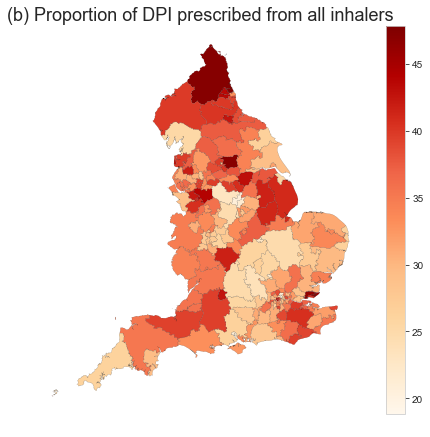

In [18]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(b) Proportion of DPI prescribed from all inhalers'),]     

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

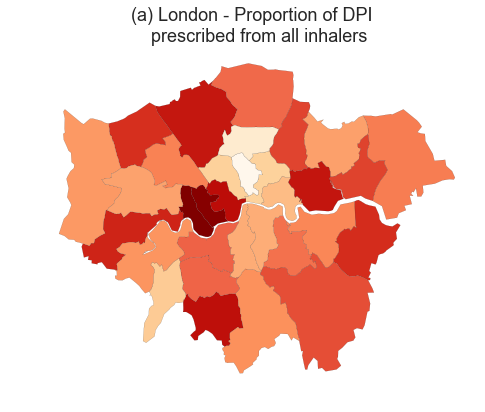

In [19]:
plt.show()# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)
gdf = gdf.loc[(gdf["pct"]=="08H") 
              | (gdf["pct"]=="07L")
              | (gdf["pct"]=="07M")
              | (gdf["pct"]=="07N")
              | (gdf["pct"]=="8M")
              | (gdf["pct"]=="07P")
              | (gdf["pct"]=="07Q")
              | (gdf["pct"]=="07R")
              | (gdf["pct"]=="09A")
              | (gdf["pct"]=="07T")
              | (gdf["pct"]=="07V")
              | (gdf["pct"]=="07X")
              | (gdf["pct"]=="07W")
              | (gdf["pct"]=="08A")
              | (gdf["pct"]=="08C")
              | (gdf["pct"]=="08D")
              | (gdf["pct"]=="08E")
              | (gdf["pct"]=="08F")
              | (gdf["pct"]=="08G")
              | (gdf["pct"]=="07Y")
              | (gdf["pct"]=="08J")
              | (gdf["pct"]=="08K")
              | (gdf["pct"]=="08L")
              | (gdf["pct"]=="08R")
              | (gdf["pct"]=="08Q")
              | (gdf["pct"]=="08T")
              | (gdf["pct"]=="08V")
              | (gdf["pct"]=="08W")
              | (gdf["pct"]=="08X")
              | (gdf["pct"]=="08Y")
              | (gdf["pct"]=="08M")
              | (gdf["pct"]=="08N")
              | (gdf["pct"]=="08P")
              ]             
            #zoom in London

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(a) London - Proportion of DPI  \n prescribed from all inhalers'),]  

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=False, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Inhalers Matching

In [20]:
## here we importat a file where all generics have been matched
genericmatchedinhalers = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTefoHueV7W523NR2uc5ckS9zJFeuWFr2v84WkzThbobQq5KPKIqlued_UqRCy31YGhF4P3XEyJWlI8/pub?gid=1298934578&single=true&output=csv"
pd.read_csv(genericmatchedinhalers).head(5)


,bnf_code,presentation,form_route,chemical,Nicola Matching,Comment,Unnamed: 6,Unnamed: 7,Brian Match,Unnamed: 9,Comment.1,Are amount of doses identical?,Difference,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,0302000C0AABFBF,Beclomet Diprop_Inha 100mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,NaN,NaN,NaN,NaN,NaN,NaN,Rxs are dropping off - is tis still available?,NaN,1,0302000C0BF,NaN,NaN
1,0302000C0AAABAB,Beclomet Diprop_Inha 100mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,NaN,NaN,NaN,NaN,NaN,NaN,Rxs are dropping off - is tis still available?,NaN,1,0302000C0AB,NaN,NaN
2,0302000C0AABVBV,Beclomet Diprop_Inha 200mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,Beclomet Diprop_Pdr For Inh 200mcg(200D),NaN,NaN,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D),NaN,NaN,NaN,1,0302000C0BV,NaN,NaN
3,0302000C0AAARAR,Beclomet Diprop_Inha 200mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,Beclomet Diprop_Pdr For Inh 200mcg(200D),NaN,NaN,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D),NaN,NaN,NaN,1,0302000C0AR,NaN,NaN
4,0302000C0AABWBW,Beclomet Diprop_Inha 250mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0302000C0BW,NaN,NaN


In [30]:
sql = '''
SELECT
  rx.bnf_name,
  rx.bnf_code,
  SUM(rx.items) AS items,
  SUM(net_cost) AS net_cost, -- we use net cost as this is what PPU figure is. Also average discount needs to be applied which varies month on month
  match_code,
  match_name,
  ppu.median_price_per_unit, --this is from the median price per unit view, gives the PPU as per Jan 2019 for generic DPI equivalent
  SUM(quantity*inh.inh_multiplication)*ppu.median_price_per_unit AS dpi_cost, --this calculates the new DPI equivalent actual cost
  (SUM(quantity*inh.inh_multiplication)*ppu.median_price_per_unit)-SUM(rx.actual_cost) AS difference --calculates the difference between the two
FROM
  `brian.inhalers_mdi_dpi` AS inh --the match table which is the file in above cell but now uploaded to BigQuery
JOIN
  `hscic.normalised_prescribing_standard_latest_month` AS rx
ON
  rx.bnf_code = inh.presentation_code --joins all brands and generic to generic in match table
LEFT JOIN 
(SELECT * FROM `measures.vw__median_price_per_unit` WHERE date = '2019-03-01') AS ppu --joins to median PPU table, specifying PPU only for January 2019
ON
  inh.match_code = ppu.bnf_code
GROUP BY
  bnf_name,
  bnf_code,
  match_code,
  match_name,
  ppu.median_price_per_unit
ORDER BY
  bnf_code'''

df_inhaler_matching = bq.cached_read(sql, csv_path='df_inhaler_matching_final.csv', use_cache=True)  # add `use_cache=False` to override

df_inhaler_matching.head(50)

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,bnf_name,bnf_code,items,net_cost,match_code,match_name,median_price_per_unit,dpi_cost,difference
0,Formoterol Fumar_Inh 12mcg (100D) CFF,0301011E0AAADAD,1951,65560.86,0301011E0AAACAC,Formoterol Fumar_Pdr For Inh 12mcg(60 D),24.80,86542.08,2.560935e+04
1,Atimos Modulite_Inh 12mcg (100D),0301011E0BDAAAD,1121,38296.44,0301011E0AAACAC,Formoterol Fumar_Pdr For Inh 12mcg(60 D),24.80,50552.32,1.496091e+04
2,Salbutamol_Inha 100mcg (200 D),0301011R0AAAAAA,40,89.55,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,198.60,1.149193e+02
3,Salbutamol_Inha 100mcg (200 D) CFF,0301011R0AAAPAP,1033226,1957883.95,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,4320403.98,2.489380e+06
4,Salbutamol_Inha B/A 100mcg (200 D) CFF,0301011R0AABUBU,65339,503551.43,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,264564.99,-2.040676e+05
5,Ventolin_Evohaler 100mcg (200 D),0301011R0BEAIAP,514195,1046852.17,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,2310055.62,1.331250e+06
6,Salamol_Inha 100mcg (200 D) CFF (Teva),0301011R0BIAFAP,33264,60573.92,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,137328.59,8.064326e+04
7,Salamol E-Breathe_Inh 100mcg (200 D) CFF,0301011R0BIAGBU,31806,251225.05,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,131992.87,-1.017792e+05
8,Airomir_Inha 100mcg (200 D),0301011R0BMAAAP,1136,2966.82,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,4984.86,2.214802e+03
9,Airomir_Autohaler 100mcg (200 D) CFF,0301011R0BMABBU,5974,44283.12,0301011R0AABZBZ,Salbutamol_Pdr For Inh 100mcg (200 D),3.31,24348.36,-1.686271e+04


In [31]:
### calculate cost impact for March but . This is latest month at time of analysis however this is will update as we have used latest month file
impact_march = df_inhaler_matching['difference'].sum()*0.9281 ## national ave discount in Feb=7.19
impact_march

6660266.360112014

In [32]:
### Extrapolate to 12 months
impact_per_annum = impact_march*12
impact_per_annum

79923196.32134417

In [33]:
## Now we need to work out how many inhalers can be directly matched i.e. what is posiible based on current market share
tot_inh_march = df_inhaler_matching['items'].sum()
tot_poss_DPI = df_inhaler_matching.loc[df_inhaler_matching['match_code'].notnull(), 'items'].sum()
propotion_DPI = (tot_poss_DPI/tot_inh_march)*100
propotion_DPI

82.09030508584007